## TODO: This is super useful - add this into basic optical gating

In [1]:
from classes.basic_optical_gating import BasicOpticalGating as BOG
from classes.basic_optical_gating import AdaptedV as BOGV
from classes.plotter import BasicOpticalGatingPlotter as BOGP
from classes.drawer import Drawer

In [2]:
sequence_src = "D:/Data/both 800fps/brightfield/*tif"
reference_src = "D:/Data/both 800fps/ref_seq.tif"
reference_period = 3.062623721828068710e+02

In [3]:
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
sequence = tf.imread(sequence_src).astype(np.int32)
reference_sequence = tf.imread(reference_src).astype(np.int32)

# Get our high framerate indices
sad = []
for j in range(sequence.shape[0]):
    sad.append(np.sum(np.abs(sequence[j] - reference_sequence[0])))
reference_min = np.argmin(sad)
reference_max = reference_min + reference_sequence.shape[0]
reference_frame_hf_indices = np.arange(reference_min, reference_max)

# Get our low framerate indices
reference_frame_lf_indices = reference_frame_hf_indices[2:-2][::8]
reference_frame_lf_indices = np.insert(reference_frame_lf_indices, 0, reference_frame_lf_indices[0] - 8)
reference_frame_lf_indices = np.insert(reference_frame_lf_indices, 0, reference_frame_lf_indices[0] - 8)
reference_frame_lf_indices = np.append(reference_frame_lf_indices, reference_frame_lf_indices[-1] + 8)
reference_frame_lf_indices = np.append(reference_frame_lf_indices, reference_frame_lf_indices[-1] + 8)

# And save our high framerate sequence (again)
reference_sequence_hf = sequence[reference_frame_hf_indices]

# and our low framerate sequence
reference_sequence_lf = sequence[reference_frame_lf_indices]

In [5]:
sads_lf = []
sads_hf = []
for i in range(sequence.shape[0]):
    sad = []
    for j in range(reference_sequence_lf.shape[0]):
        sad.append(np.sum(np.abs(reference_sequence_lf[j] - sequence[i])))

    sads_lf.append(sad)

    sad = []
    for j in range(reference_sequence_hf.shape[0]):
        sad.append(np.sum(np.abs(reference_sequence_hf[j] - sequence[i])))

    sads_hf.append(sad)

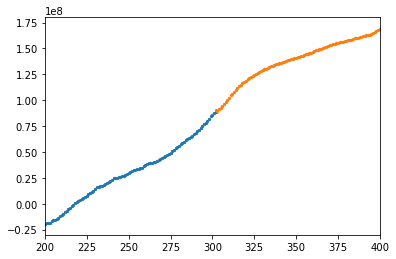

In [33]:
minima = np.argmin(sads_hf[0][2:-2]) + 2

plt.scatter(reference_frame_hf_indices[0:minima], -np.array(sads_hf[0][0:minima] - 2 * sads_hf[0][minima]) - 1500000, s = 5)
plt.scatter(reference_frame_hf_indices[minima - 1:-1], sads_hf[0][minima - 1:-1], s = 5)
plt.xlim(200,400)
plt.ylim(-0.3e8, 1.8e8)
plt.show()

In [7]:
og_hf = BOG()
og_hf.settings["drift_correction"] = True
og_hf.set_sequence(sequence.astype(np.uint16))
og_hf.set_reference_sequence(reference_sequence_hf.astype(np.uint16))
og_hf.set_reference_period(3.062623721828068710e+02)
og_hf.run()

og_lf = BOG()
og_hf.settings["drift_correction"] = True
og_lf.set_sequence(sequence.astype(np.uint16))
og_lf.set_reference_sequence(reference_sequence_lf.astype(np.uint16))
og_lf.set_reference_period(3.062623721828068710e+02 / 8)
og_lf.run()

In [8]:
print(og_hf)
print()
print(og_lf)

Basic optical gating class
Run:
	set_sequence: True
	set_reference_sequence: True
	get_sads: True
	get_phases: True
	get_delta_phases: True
	get_unwrapped_phases: True
	set_region_of_interest: False
Settings:
	matching_method:jSAD
	drift_correction: True
	clear_memory: False


Basic optical gating class
Run:
	set_sequence: True
	set_reference_sequence: True
	get_sads: True
	get_phases: True
	get_delta_phases: True
	get_unwrapped_phases: True
	set_region_of_interest: False
Settings:
	matching_method:jSAD
	drift_correction: False
	clear_memory: False



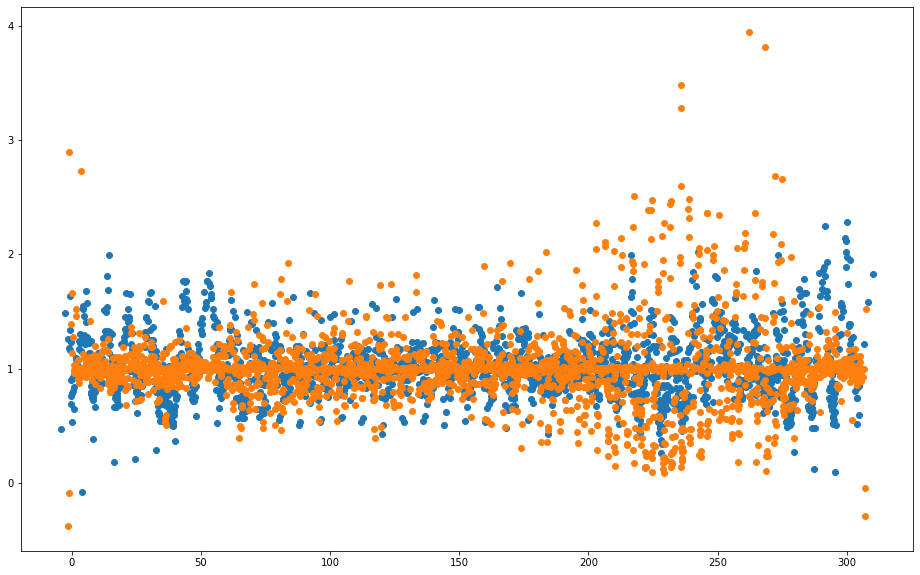

In [9]:
plt.figure(figsize = (16,10))
plt.scatter(og_lf.phases[1::] * 8, og_lf.delta_phases * 8)
plt.scatter(og_hf.phases[1::], og_hf.delta_phases)
plt.show()

### TODO: Do minimisation to find scale and offset factors s.t frame SAD matches ref SAD
### TODO: Do what I've done below i.e match SAD for ref seq to future frame w/ rbc data

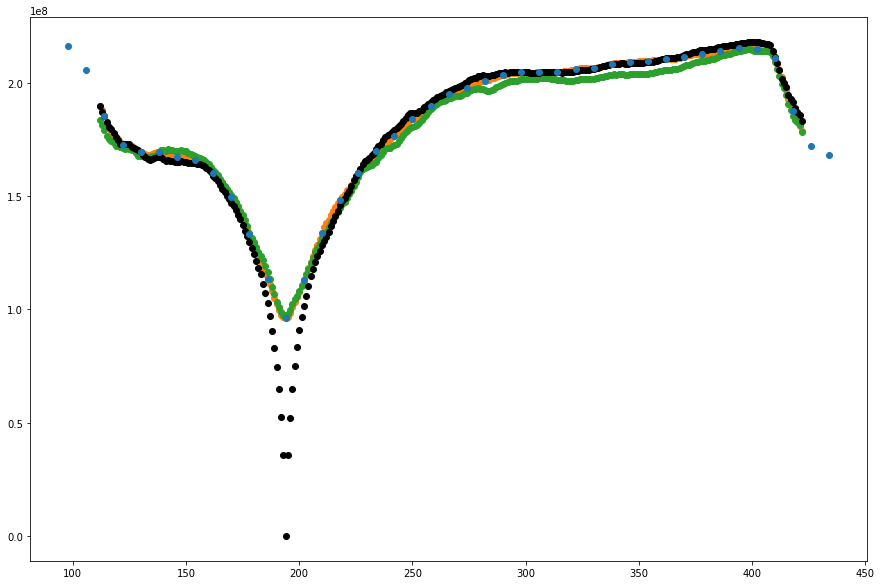

In [10]:
frame = 500

plt.figure(figsize = (15, 10))
scale = 1
# What does this offset represent?
# TODO: Calculate the average pixel difference - do this for a few datasets
offset = 0.96e8
plt.scatter(reference_frame_lf_indices, scale * (sads_lf[frame] - np.min(sads_lf[frame])) + offset, zorder = 100)
plt.scatter(reference_frame_hf_indices, scale * (sads_hf[frame] - np.min(sads_hf[frame])) + offset)
plt.scatter(reference_frame_hf_indices, scale * (sads_hf[frame+616] - np.min(sads_hf[frame])) + offset,)
plt.scatter(reference_frame_hf_indices, sads_hf[194], c = "black")
#plt.xlim(170, 210)
#plt.ylim(-0.05e8, 1.4e8)
plt.show()